# Sudoku and Graph coloring

## Introduction and intuition building

Sudoku is a popular number-placement puzzle based on logic and combinatorics. The objective is to fill a 9 × 9 grid with digits such that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid contain all of the digits from 1 to 9 (once and only once). Usually the puzzle is partially filled in a way that guarantees a unique solution, as of now from what we know at least 17 cues are needed to create a puzzle with a unique solution.

Another way of looking at this puzzle is as follows:

- View the 81 cells as nodes of a graph
- Consider the connections(being in the same row, column or grid) as edges

This is the graph-theoretic framing of the problem, after this point we can treat the Sudoku as a vertex coloring problem, where we assign a color to each number(1-9) and ensure that no two nodes of the same color are connected by an edge (thus satisfying the constraints provided)

> In the mathematics of Sudoku, the Sudoku graph is an undirected graph whose vertices represent the cells of a (blank) Sudoku puzzle and whose edges represent pairs of cells that belong to the same row, column, or block of the puzzle. The problem of solving a Sudoku puzzle can be represented as precoloring extension on this graph. It is an integral Cayley graph.

[Wikipedia - Sudoku Graph](https://en.wikipedia.org/wiki/Sudoku_graph)

Here *pre-coloring extension* simply means translating the pre-existing cues into a graph with 81 nodes, coloring the nodes that are already given as clues, and then trying to color the rest of the vertices within the contraints.

*cayley graph* is simply a way of encoding information about group in a graph, as in we can define the sudoku puzzle completely in terms of a Graph, without missing any logical information or mathematical properties

## Problem Formulation

Informally the Sudoku graph is an undirected graph- its vertices represent the cells and edges represent pairs of cells that belong to the same row, column, or block of the puzzle. Formally this can be defined as:

> A Sudoku grid of rank $n$ is a $n^2 × n^2$ grid($X_n$). 
> It consists of $n^2$ disjoint $n × n$ grids.
> The graph of $X_n$, denoted as $GX_n$, is $(V, E)$ where cells of Sudoku grid
> form the vertices of its graph and two cells are adjacent if they are either
> in the same row or column or block of $X_n$.
> $GX_n$ is a regular $(n^4, \frac{3n^6}{2} − n^5− \frac{n^4}{2})$ graph of
> degree 
> 
$$
3n^2 − 2n − 1  (1)
$$

[Wikipedia - Sudoku Graph](https://en.wikipedia.org/wiki/Sudoku_graph)

Now, from (1) we can get that the graph of a Sudoku grid of rank 3 is a $(V=81, E=810)$ regular graph of degree 20. This can be verified informally- we have 81 cells in the standard sudoku where every cell is adjacent to 8 cells in its row + 8 cells in its column and 4 more leftover cells in its block, hence the degree 20, [this Wikipedia figure](https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/9x9_Sudoku_graph_neighbors_%28really_fixed%29.svg/600px-9x9_Sudoku_graph_neighbors_%28really_fixed%29.svg.png) makes this visualization more understandable

Let's take an example Sudoku Puzzle that we will solve with graph theory (NetworkX and some cool figures as well!)

In [1]:
import numpy as np

puzzle = np.asarray(
    [
        [0, 4, 3, 0, 8, 0, 2, 5, 0],
        [6, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 9, 4],
        [9, 0, 0, 0, 0, 4, 0, 7, 0],
        [0, 0, 0, 6, 0, 8, 0, 0, 0],
        [0, 1, 0, 2, 0, 0, 0, 0, 3],
        [8, 2, 0, 5, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 3, 4, 0, 9, 0, 7, 1, 0],
    ]
)

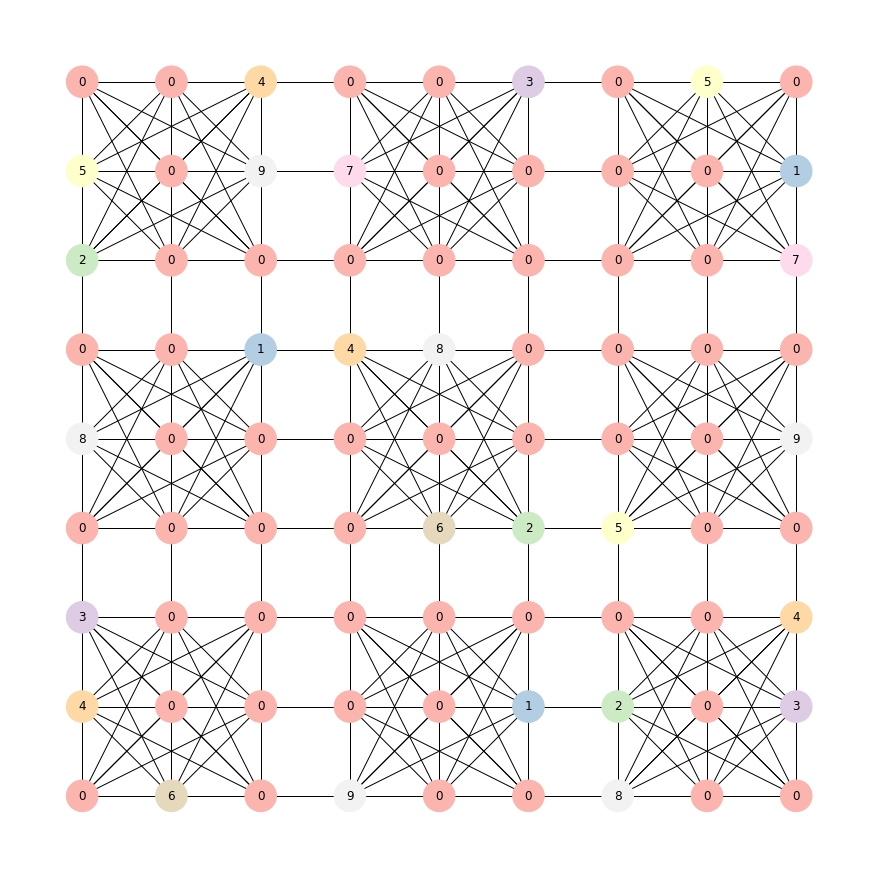

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

n = 3
G = nx.sudoku_graph(n)
mapping = dict(zip(G.nodes(), puzzle.flatten()))
pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(n * n, n * n)))

# we map the nodes 1-9 to a colormap
low, *_, high = sorted(mapping.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Pastel1)

plt.figure(figsize=(12, 12))
nx.draw(
    G,
    labels=mapping,
    pos=pos,
    with_labels=True,
    node_color=[mapper.to_rgba(i) for i in mapping.values()],
    width=1,
    node_size=1000,
)
plt.show()

Now this can be solved using greedy graph coloring algorithms, it's an NP hard problem, so some level of brute force is part of the process

> A k-coloring of a graph G is a vertex coloring that is an assignment of one of k possible colors to each vertex of G (i.e., a vertex coloring) such that no two adjacent vertices receive the same color.

How many colors would we need in this case? 9

Note: this is more than intuition, formally 9 is the chromatic number of a 2-distant coloring problem for a sudoku graph $n^2 * n^2$, you can learn more about this [here](https://mast.queensu.ca/~murty/sudoku-ams.pdf)!

Let's generate a solved grid which we'll try to visualize

In [3]:
from random import sample


# Generate random sudoku
def generate_random_sudoku(n):
    side = n * n

    def _pattern(r, c):
        return (n * (r % n) + r // n + c) % side

    rBase = range(n)
    rows = [g * n + r for g in sample(rBase, n) for r in sample(rBase, n)]
    cols = [g * n + c for g in sample(rBase, n) for c in sample(rBase, n)]
    nums = sample(range(1, n * n + 1), n * n)
    board = [nums[_pattern(r, c)] for r in rows for c in cols]
    return board

So now we modify our mapping of nodes to this solved sudoku

In [4]:
board = generate_random_sudoku(n)
mapping = dict(zip(G.nodes(), board))

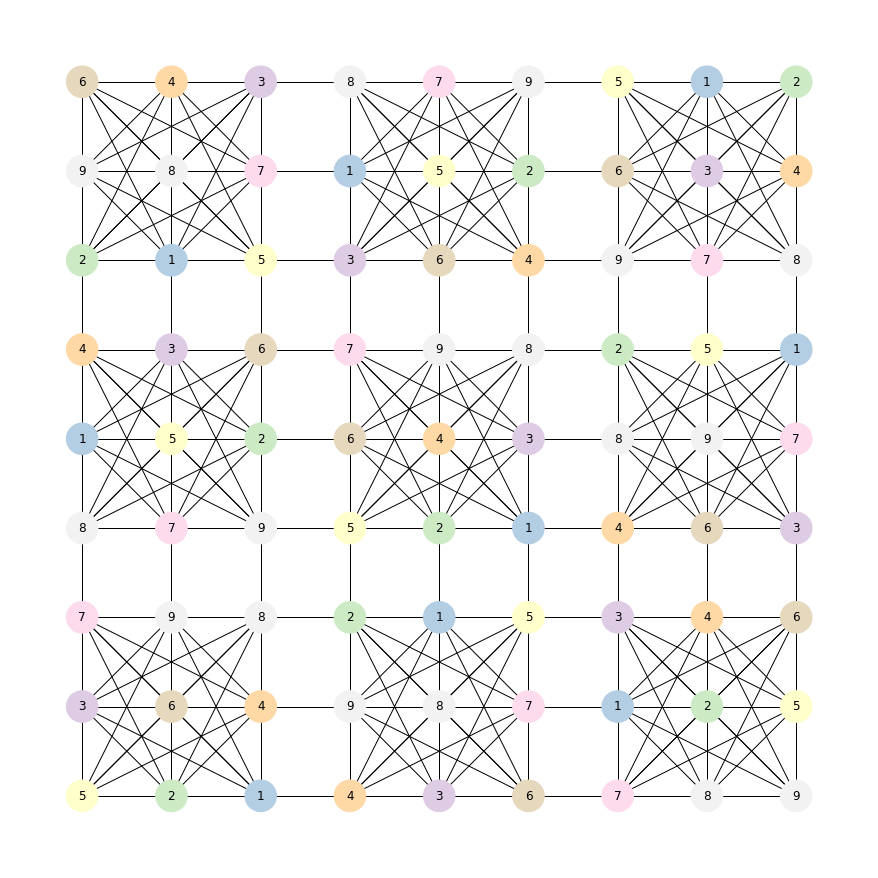

In [5]:
plt.figure(1, figsize=(12, 12))
nx.draw(
    G,
    pos=pos,
    labels=mapping,
    node_size=1000,
    node_color=[mapper.to_rgba(i) for i in mapping.values()],
    with_labels=True,
)

plt.show()

In [6]:
G = nx.sudoku_graph(n=3)

In [7]:
len(G.edges())

810

To understand and visualize the constraints of same row, box or column, looking more carefully at the edges might be useful

For starters, say we have this graph `G`, now say we want to check all the three different kinds of constraints individually, one would need to differentiate between the three different kinds of edges(there are 810!), let's do that!

Let's just have a quick look at what networkx draws in an empty(uncolored or unlabeled) sudoku graph

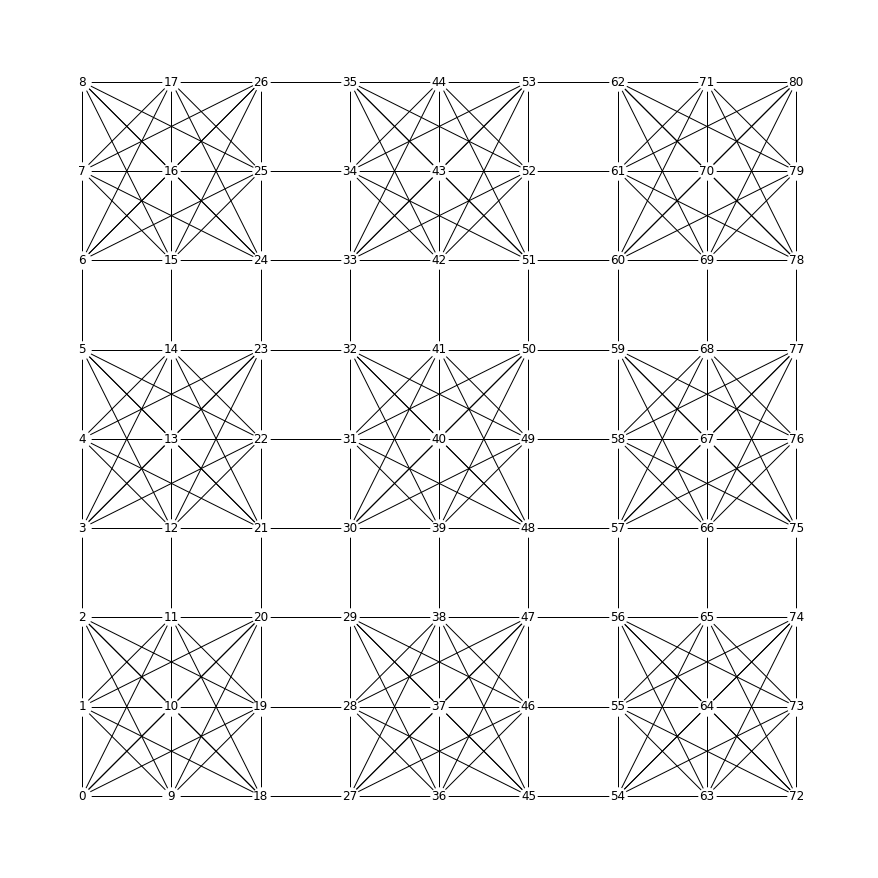

In [8]:
plt.figure(figsize=(12, 12))
pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(n * n, n * n)))
nx.draw(G, pos=pos, node_color="white", with_labels=True)
plt.show()

There you go, so all the nodes are indexed as stacks of columns from 0 to 80, now we'll separate the three different types of edges here

In [9]:
import itertools


def separate_edges(n):
    G = nx.sudoku_graph(n)
    box_edges = []
    row_edges = []
    column_edges = []
    boxes = []
    for i in range(n):
        for j in range(n):
            box = [
                (n) * i + j * (n * n * n) + (n * n) * k + l
                for k in range(n)
                for l in range(n)
            ]
            boxes.append(box)

    for i in range(n * n):
        row_edges += list(
            itertools.combinations([i + (n * n) * j for j in range(n * n)], 2)
        )
        box_edges += list(itertools.combinations(boxes[i], 2))
        column_edges += list(
            itertools.combinations(list(G.nodes())[i * (n * n) : (i + 1) * (n * n)], 2)
        )
    return row_edges, box_edges, column_edges


def plot_edge_colored_sudoku(n=3, layout="grid"):
    row_edges, box_edges, column_edges = separate_edges(n)
    G = nx.sudoku_graph(n)
    board = generate_random_sudoku(n)
    mapping = dict(zip(G.nodes(), board))

    plt.figure(figsize=(12, 12))
    if layout == "circular":
        pos = nx.circular_layout(G)
    if layout == "grid":
        pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(n * n, n * n)))

    nx.draw(G, pos=pos, labels=mapping, with_labels=True, node_color="orange")
    nx.draw_networkx_edges(G, pos=pos, edgelist=box_edges, edge_color="tab:gray")
    nx.draw_networkx_edges(
        G, pos=pos, edgelist=row_edges, width=2, edge_color="tab:blue"
    )
    nx.draw_networkx_edges(
        G, pos=pos, edgelist=column_edges, width=2, edge_color="tab:green"
    )
    plt.show()

Alright time to plot!!

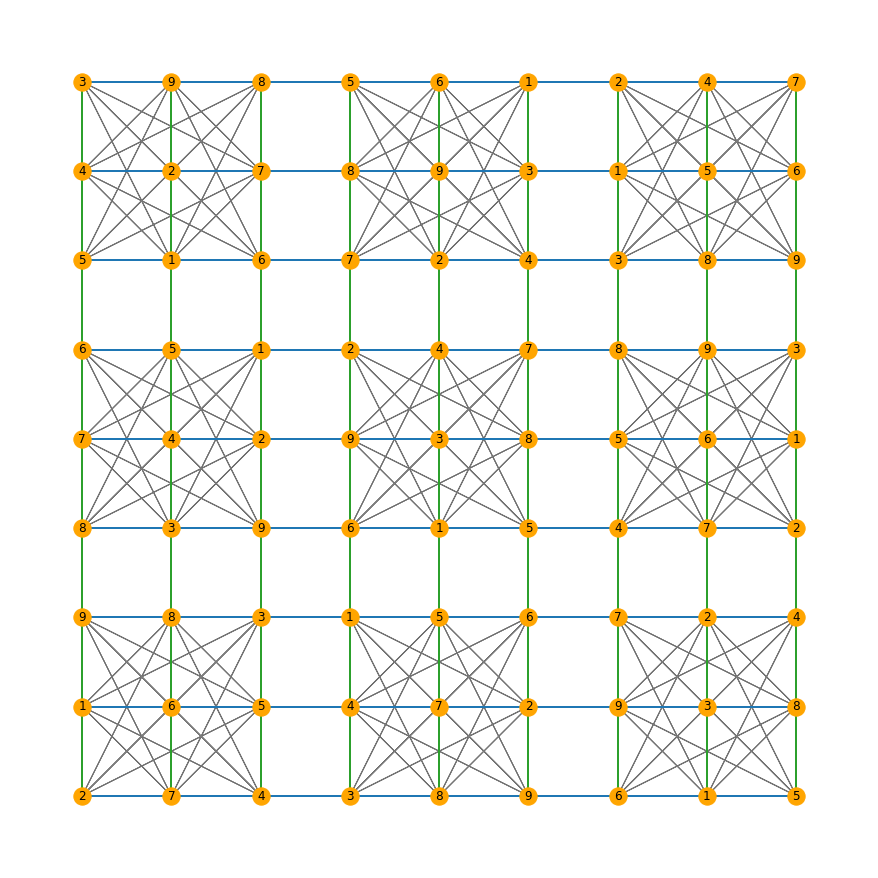

In [10]:
plot_edge_colored_sudoku()

Let's change the layout a little to see all the edges that are invisible because they fall on top of each other

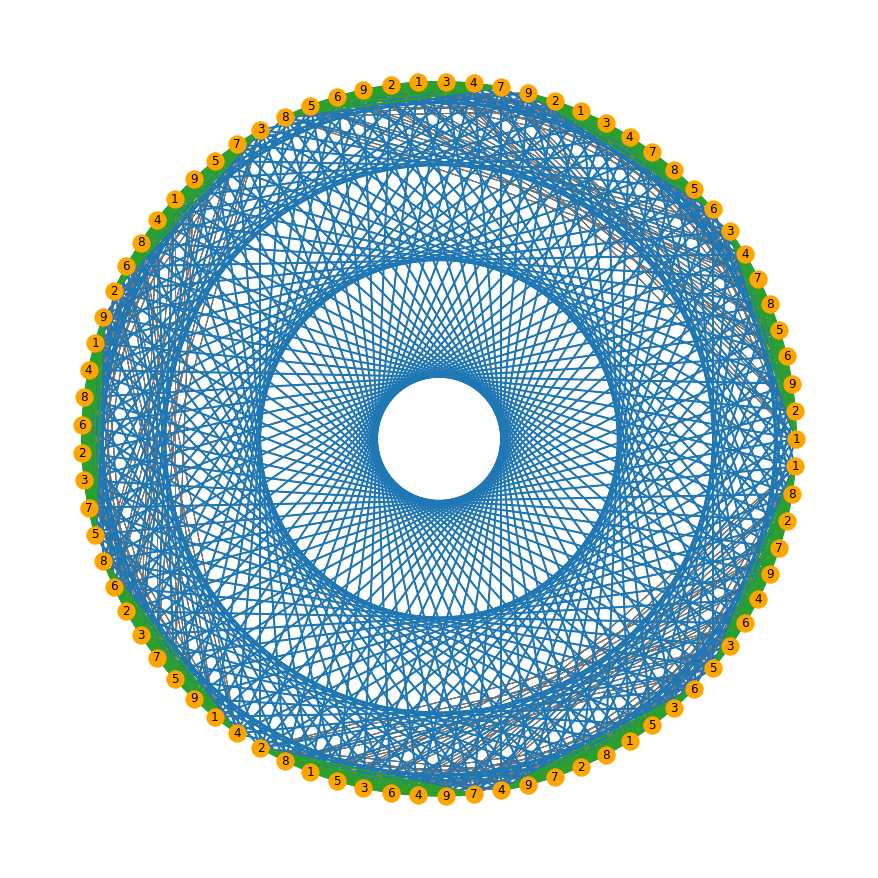

In [11]:
plot_edge_colored_sudoku(layout="circular")

pretty! Now, let's check how do sudoku graphs look if sudokus were 16 x 16 grids instead of 9 x 9

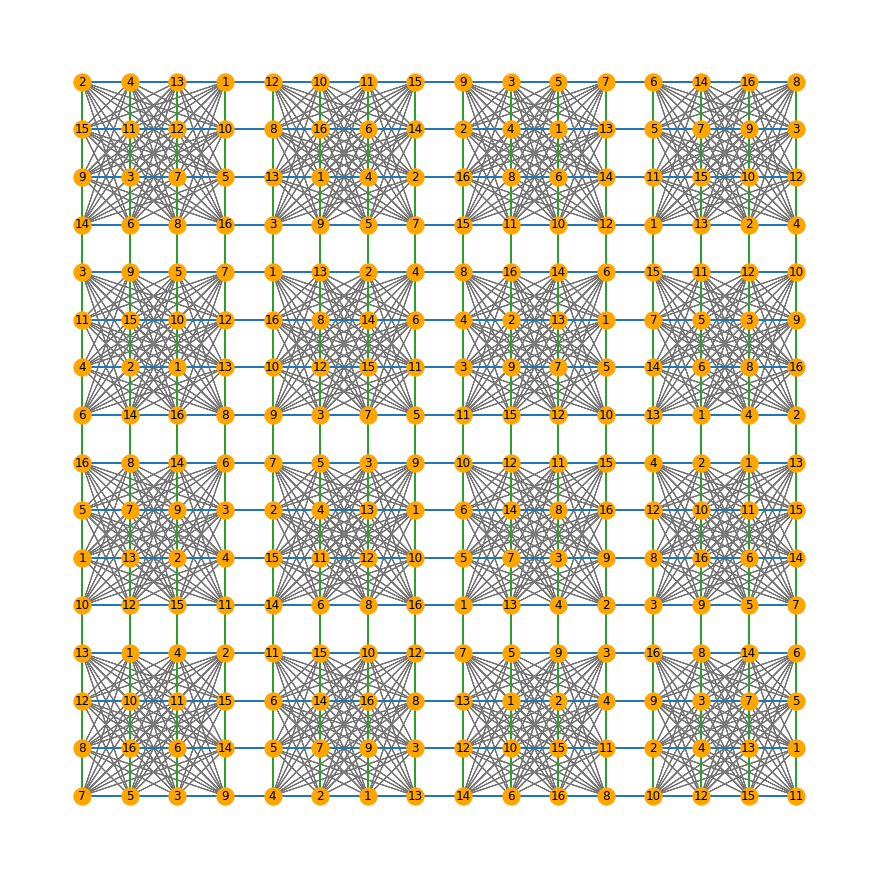

In [12]:
plot_edge_colored_sudoku(n=4)